## Full Project Pipline

In [1]:
import sys
import os
import pandas as pd
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

from Data.TextData.Subsample import sample_data, process_and_save
from Data.TextData.MergeData import merge_data
from Data.ImageData.select_tifs import copy_tif_files
from Modelling.TrainTestSplit.TrainTestSplitNew import process_text_data, oversample_classes, split_data, generate_and_save_augmented_images
from Data.ImageData.SplitImagesNew import extract_vignettes
from Modelling.CNN.CNNnew import preprocess_data, create_tf_datasets, build_model, cnn_evaluate_model, plot_hist
from Modelling.MLP.MLPnew import load_and_preprocess, mlp_evaluate_model
from Modelling.CollaborativeModel.CollabModelNew import prepare_data, train_collaborative_model, match_particle_counts, map_str_to_int, extract_image_data
from Modelling.CollaborativeModel.CollabModelNew import process_image_df, remove_cols, load_and_preprocess_image, create_tf_dataset, input_preprocess, get_attr_labels

## Create subsample


In [2]:
# Set base directory and output directory
base_dir = "/Users/adelelauzon/Desktop/MSc/STA5243"
output_dir = "/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Data/TextData"
# Read in Master Table (environmental data)
master = pd.read_excel("/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Data/TextData/MasterTable_AI_FlowCAM.xlsx", sheet_name="MasterTable")
# Take a random subsample of 70 rows. 
# Recall that each row here represents a mosaic. 
subsample = sample_data(master, n=100, seed=1013)
subsample = process_and_save(subsample, base_dir=base_dir, output_dir=output_dir, output_file="subsample.csv")



In [3]:
subsample

,tifffile,csvfile,Year,SAM,Month,Day,Rep,repnum,Key,Loc,...,volbest,WhitefishDen,UnknwCoregonine,CiscoDen,Exposure,SmeltDen,YPerchDen,BurbotDen,OtherFishDen,ODLocation
4489,20180509_Huron_139_2mm_rep2_000274.tif,20180509_FISHI_139_2mm_rep2_data.csv,2018,139,5,9,rep2,2,2018.Huron.139.2,FISHI,...,39.171520,0.021116,0.000000,0.014077,6.776995e+06,0.0,0.0,0.000000,0.0,/Users/adelelauzon/Desktop/MSc/STA5243/CSVs/20...
3850,20180508_Huron_127_2mm_rep3_000105.tif,20180508_FISHI_127_2mm_rep3_data.csv,2018,127,5,8,rep3,3,2018.Huron.127.3,FISHI,...,36.785129,0.329737,0.000000,0.223750,6.627470e+06,0.0,0.0,0.000000,0.0,/Users/adelelauzon/Desktop/MSc/STA5243/CSVs/20...
4062,20180509_Huron_139_2mm_rep1_000150.tif,20180509_FISHI_139_2mm_rep1_data.csv,2018,139,5,9,rep1,1,2018.Huron.139.1,FISHI,...,39.171520,0.021116,0.000000,0.014077,6.776995e+06,0.0,0.0,0.000000,0.0,/Users/adelelauzon/Desktop/MSc/STA5243/CSVs/20...
4261,20180509_Huron_139_2mm_rep2_000046.tif,20180509_FISHI_139_2mm_rep2_data.csv,2018,139,5,9,rep2,2,2018.Huron.139.2,FISHI,...,39.171520,0.021116,0.000000,0.014077,6.776995e+06,0.0,0.0,0.000000,0.0,/Users/adelelauzon/Desktop/MSc/STA5243/CSVs/20...
2297,20170512_Huron_205_2mm_rep3_000008.tif,20170512_FISHI_205_2mm_rep3_CT_data.csv,2017,205,5,12,rep3,3,2017.Huron.205.3,FISHI,...,13.451567,0.000000,0.012661,0.025323,1.276916e+06,0.0,0.0,0.000000,0.0,/Users/adelelauzon/Desktop/MSc/STA5243/CSVs/20...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5994,20180528_Huron_303_2mm_rep2_000002.tif,20180528_FISHI_303_2mm_rep2_data.csv,2018,303,5,28,rep2,2,2018.Huron.303.2,FISHI,...,35.823405,0.000000,0.000000,0.007229,2.296381e+07,0.0,0.0,0.000000,0.0,/Users/adelelauzon/Desktop/MSc/STA5243/CSVs/20...
5768,20180528_Huron_293_2mm_rep3_000015.tif,20180528_FISHI_293_2mm_rep3_data.csv,2018,293,5,28,rep3,3,2018.Huron.293.3,FISHI,...,36.173821,0.013702,0.000000,0.000000,2.105144e+06,0.0,0.0,0.000000,0.0,/Users/adelelauzon/Desktop/MSc/STA5243/CSVs/20...
380,04152021_Huron_12_2mm_Rep2_MS_000004.tif,20210415_NOTTA_012_2mm_Rep2_MS_data.csv,2021,12,4,15,Rep2,2,2021.Huron.012.2,NOTTA,...,36.704553,0.018730,0.000000,0.000000,1.106982e+07,0.0,0.0,0.006243,0.0,/Users/adelelauzon/Desktop/MSc/STA5243/CSVs/20...
3363,20180507_Huron_107_2mm_rep2_000003.tif,20180507_FISHI_107_2mm_rep2_data.csv,2018,107,5,7,rep2,2,2018.Huron.107.2,FISHI,...,36.047063,0.050959,0.000000,0.012740,5.608114e+04,0.0,0.0,0.000000,0.0,/Users/adelelauzon/Desktop/MSc/STA5243/CSVs/20...


In [4]:
# Define input and output directories
base_dir = "/Users/adelelauzon/Desktop/MSc/STA5243"
output_dir = "/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Data/TextData"

# Load input datasets
geometric = pd.read_csv("/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Data/TextData/subsample.csv")  
environmental = pd.read_excel("/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Data/TextData/MasterTable_AI_FlowCAM.xlsx", sheet_name="MasterTable")



In [5]:
merged_data = merge_data(base_dir, output_dir, subsample, master)


File not found: /Users/adelelauzon/Desktop/MSc/STA5243/CSVs/20170511_FISHI_171_2mm_rep2_CT_data.csv
Finished searching through the list of CSV files.


In [6]:
cleaned_merged = pd.read_csv("Data/TextData/cleaned_merged.csv")
cleaned_merged

,Class.Particle.ID,Class,Area..ABD.,Area..Filled.,Aspect.Ratio,Calibration.Image,Capture.X,Capture.Y,Circle.Fit,Circularity,...,distshore,FR,volbest,WhitefishDen,UnknwCoregonine,CiscoDen,Exposure,YPerchDen,BurbotDen,OtherFishDen
0,1,Calanoid_1,184832.1222,184914.5620,0.2661,1,338,1163,0.0000,0.2986,...,317.306866,Random,39.171520,0.021116,0.0,0.014077,6.776995e+06,0.0,0.0,0.0
1,2,Calanoid_1,154930.7762,154930.7762,0.2678,1,766,505,0.0146,0.3066,...,317.306866,Random,39.171520,0.021116,0.0,0.014077,6.776995e+06,0.0,0.0,0.0
2,3,Calanoid_1,172647.9199,172647.9199,0.2589,1,920,984,0.0000,0.4382,...,317.306866,Random,39.171520,0.021116,0.0,0.014077,6.776995e+06,0.0,0.0,0.0
3,4,Calanoid_1,212278.5592,212775.9014,0.3801,1,652,905,0.0000,0.3100,...,317.306866,Random,39.171520,0.021116,0.0,0.014077,6.776995e+06,0.0,0.0,0.0
4,5,Calanoid_1,219245.3018,219245.3018,0.3924,1,884,1824,0.0222,0.3473,...,317.306866,Random,39.171520,0.021116,0.0,0.014077,6.776995e+06,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22298,3,Herpacticoida,56878.1351,56955.5595,0.6121,1,286,349,0.3618,0.3030,...,118.099515,Fixed,44.482885,0.000000,0.0,0.016613,1.735401e+05,0.0,0.0,0.0
22299,1,Chironomid,77298.6500,77298.6500,0.4440,1,896,891,0.1370,0.3302,...,118.099515,Fixed,44.482885,0.000000,0.0,0.016613,1.735401e+05,0.0,0.0,0.0
22300,2,Chironomid,84582.1810,84582.1810,0.2219,1,457,315,0.0000,0.3120,...,118.099515,Fixed,44.482885,0.000000,0.0,0.016613,1.735401e+05,0.0,0.0,0.0
22301,3,Chironomid,43604.7071,43604.7071,0.1826,1,818,111,0.0000,0.2895,...,118.099515,Fixed,44.482885,0.000000,0.0,0.016613,1.735401e+05,0.0,0.0,0.0


In [19]:
class_counts = cleaned_merged["Class"].value_counts()
class_counts

Class
Calanoid_1       15290
Bosmina_1         1601
Chironomid         524
Herpacticoida      402
Chydoridae          35
Daphnia              6
Name: count, dtype: int64

### Preprocess Data

In [20]:
# Select relevant tif files
source_dir = "/Users/adelelauzon/Desktop/MSc/STA5243/HURON_OverlapTiffsWithPP"
output_dir = "/Users/adelelauzon/Desktop/MSc/STA5243/tifs"
data_cleaned_path = "/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Data/TextData/cleaned_merged.csv"

copy_tif_files(source_dir, output_dir, data_cleaned_path) 


File not found: /Users/adelelauzon/Desktop/MSc/STA5243/HURON_OverlapTiffsWithPP/20180509_Huron_139_2mm_rep1_000165.tif
File not found: /Users/adelelauzon/Desktop/MSc/STA5243/HURON_OverlapTiffsWithPP/20180509_Huron_139_2mm_rep1_000170.tif
File not found: /Users/adelelauzon/Desktop/MSc/STA5243/HURON_OverlapTiffsWithPP/20180509_Huron_139_2mm_rep1_000183.tif
File not found: /Users/adelelauzon/Desktop/MSc/STA5243/HURON_OverlapTiffsWithPP/20180509_Huron_139_2mm_rep1_000185.tif
File not found: /Users/adelelauzon/Desktop/MSc/STA5243/HURON_OverlapTiffsWithPP/20180509_Huron_139_2mm_rep1_000186.tif
File not found: /Users/adelelauzon/Desktop/MSc/STA5243/HURON_OverlapTiffsWithPP/20180509_Huron_139_2mm_rep1_000200.tif
File not found: /Users/adelelauzon/Desktop/MSc/STA5243/HURON_OverlapTiffsWithPP/20180509_Huron_139_2mm_rep1_000202.tif
File not found: /Users/adelelauzon/Desktop/MSc/STA5243/HURON_OverlapTiffsWithPP/20180509_Huron_139_2mm_rep1_000205.tif
File not found: /Users/adelelauzon/Desktop/MSc/S

In [21]:
# Split the tif mosaics into particles
extract_vignettes("/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Data/TextData/cleaned_merged.csv", 
                      "/Users/adelelauzon/Desktop/MSc/STA5243/tifs", 
                      "/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Data/ImageData/vignettes", 
                      "/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Data/ImageData/extracted_particles.csv")


Extracted vignette: 20190604_FISHI_336_2mm_rep1_KG_000001_vign000000.png
Extracted vignette: 20190604_FISHI_336_2mm_rep1_KG_000002_vign000001.png
Extracted vignette: 20190604_FISHI_336_2mm_rep1_KG_000002_vign000002.png
Extracted vignette: 20190604_FISHI_336_2mm_rep1_KG_000003_vign000003.png
Extracted vignette: 20190604_FISHI_336_2mm_rep1_KG_000003_vign000004.png
Extracted vignette: 20190604_FISHI_336_2mm_rep1_KG_000003_vign000005.png
Extracted vignette: 20190604_FISHI_336_2mm_rep1_KG_000004_vign000006.png
Extracted vignette: 20190604_FISHI_336_2mm_rep1_KG_000005_vign000007.png
Extracted vignette: 20190604_FISHI_336_2mm_rep1_KG_000005_vign000008.png
Extracted vignette: 20190604_FISHI_336_2mm_rep1_KG_000005_vign000009.png
Extracted vignette: 20190604_FISHI_336_2mm_rep1_KG_000005_vign000010.png
Extracted vignette: 20190604_FISHI_336_2mm_rep1_KG_000006_vign000011.png
Extracted vignette: 20190604_FISHI_336_2mm_rep1_KG_000006_vign000012.png
Extracted vignette: 20190604_FISHI_336_2mm_rep1_KG_

In [2]:
particle_path = "/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Data/ImageData/extracted_particles.csv"  
text_data_path = "/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Data/TextData/cleaned_merged.csv"  
particles = pd.read_csv(particle_path)
text_data = pd.read_csv(text_data_path)
text_all_cleaned = process_text_data(text_data, seed=42)

# Specify the classes you want to oversample
classes_to_oversample = ('Chydoridae', 'Daphnia')  
train_img, val_img, test_img, train_text, val_text, test_text = split_data(particles, text_all_cleaned, classes_to_oversample, target_count=100)

vignettes_folder = "/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Data/ImageData/vignettes"  

# Generate augmented images for each oversampled class
augmented_images = []
for class_label in classes_to_oversample:
    train_class = train_img[train_img['Class'] == class_label]
    aug_images = generate_and_save_augmented_images(train_class, vignettes_folder, class_label=class_label)
    augmented_images.extend(aug_images)

augmented_df = pd.DataFrame(augmented_images, columns=["Vignette", "Class"])
train_img = pd.concat([train_img, augmented_df])

train_img.to_csv("/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Data/ImageData/image_train.csv", index=False)
val_img.to_csv("/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Data/ImageData/image_val.csv", index=False)
test_img.to_csv("/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Data/ImageData/image_test.csv", index=False)
train_text.to_csv("/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Data/TextData/text_train.csv", index=False)
val_text.to_csv("/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Data/TextData/text_val.csv", index=False)
test_text.to_csv("/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Data/TextData/text_test.csv", index=False)
print("Data augmentation and saving completed.")

Generated 2 augmented images for 20170510_Huron_163_2mm_rep3_000012_vign015769.png
Generated 2 augmented images for 20170524_Huron_273_2mm_rep3_000022_vign014564.png
Generated 2 augmented images for 20170510_Huron_163_2mm_rep3_000050_vign016140.png
Generated 2 augmented images for 20170428_Huron_090_2mm_rep2_000019_vign016928.png
Generated 2 augmented images for 20180529_Huron_323_2mm_rep3_000052_vign013173.png
Generated 2 augmented images for 20170511_Huron_171_2mm_rep2_000011_vign013256.png
Generated 2 augmented images for 20170510_Huron_163_2mm_rep1_000001_vign015130.png
Generated 2 augmented images for 20170511_Huron_171_2mm_rep2_000012_vign013259.png
Generated 2 augmented images for 20170428_Huron_090_2mm_rep2_000006_vign016894.png
Generated 2 augmented images for 20170524_Huron_269_2mm_rep1_000033_vign001470.png
Generated 2 augmented images for 20170510_Huron_163_2mm_rep3_000028_vign015920.png
Generated 2 augmented images for 20170510_Huron_163_2mm_rep1_000038_vign015466.png
Gene

### CNN

In [10]:
train_df = pd.read_csv("/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Data/ImageData/image_train.csv")
val_df = pd.read_csv("/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Data/ImageData/image_val.csv")
test_df = pd.read_csv("/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Data/ImageData/image_test.csv")
base_path = "/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Data/ImageData/vignettes/"
fig_output_dir = "/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Modelling/CNN/model_accuracy.png"
metrics_output_dir = "/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Modelling/CNN/performance_metrics.txt"
model_output_dir = '/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Modelling/CNN/cnn_final_model.keras'

train_df, val_df, test_df, num_classes = preprocess_data(train_df, val_df, test_df, base_path)
train_ds, val_ds, test_ds = create_tf_datasets(train_df, val_df, test_df, num_classes)
model = build_model(num_classes)
hist = model.fit(train_ds, epochs=25, validation_data=val_ds)
plot_hist(hist, fig_output_dir)
model.save(model_output_dir)
cnn_evaluate_model(model, test_ds, test_df, metrics_output_dir)


Epoch 1/25
186/186 ━━━━━━━━━━━━━━━━━━━━ 500s 3s/step - accuracy: 0.2501 - loss: 2.2222 - val_accuracy: 0.8113 - val_loss: 1.0844
Epoch 2/25
186/186 ━━━━━━━━━━━━━━━━━━━━ 545s 3s/step - accuracy: 0.5726 - loss: 1.2410 - val_accuracy: 0.9238 - val_loss: 0.5799
Epoch 3/25
186/186 ━━━━━━━━━━━━━━━━━━━━ 529s 3s/step - accuracy: 0.7890 - loss: 0.7223 - val_accuracy: 0.9521 - val_loss: 0.3212
Epoch 4/25
186/186 ━━━━━━━━━━━━━━━━━━━━ 522s 3s/step - accuracy: 0.8962 - loss: 0.4226 - val_accuracy: 0.9586 - val_loss: 0.2089
Epoch 5/25
186/186 ━━━━━━━━━━━━━━━━━━━━ 542s 3s/step - accuracy: 0.9332 - loss: 0.2844 - val_accuracy: 0.9624 - val_loss: 0.1556
Epoch 6/25
186/186 ━━━━━━━━━━━━━━━━━━━━ 537s 3s/step - accuracy: 0.9438 - loss: 0.2271 - val_accuracy: 0.9639 - val_loss: 0.1282
Epoch 7/25
186/186 ━━━━━━━━━━━━━━━━━━━━ 532s 3s/step - accuracy: 0.9515 - loss: 0.1828 - val_accuracy: 0.9662 - val_loss: 0.1111
Epoch 8/25
186/186 ━━━━━━━━━━━━━━━━━━━━ 530s 3s/step - accuracy: 0.9542 - loss: 0.1668 - val_accu

todo: smaller learning rate
tf.image.grayscale_to_rgb 



### MLP

In [2]:
base_path = "/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Data/TextData/"
model_output_dir = '/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Modelling/MLP/final_mlp_model.keras'
fig_output_dir = "/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Modelling/MLP/model_accuracy.png"
metrics_output_dir = "/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Modelling/MLP/performance_metrics.txt"

# Load datasets
text_train, text_val, text_test = [load_and_preprocess(file, base_path) for file in 
                                    ["text_train.csv", "text_val.csv", "text_test.csv"]]


# Feature and label extraction
feature_columns = [col for col in text_train.columns if not col.startswith('class_')]
class_columns = [col for col in text_train.columns if col.startswith('class_')]

X_train, y_train = text_train[feature_columns].to_numpy(), text_train[class_columns].to_numpy()
X_val, y_val = text_val[feature_columns].to_numpy(), text_val[class_columns].to_numpy()
X_test, y_test = text_test[feature_columns].to_numpy(), text_test[class_columns].to_numpy()

input_shape, num_classes = X_train.shape[1], len(class_columns)



In [3]:
# Evaluate model
mlp_evaluate_model(X_train, y_train, X_test, y_test, X_val, y_val, input_shape, num_classes, model_output_dir, metrics_output_dir, fig_output_dir, num_epochs=25)


Training: 1 layers, 256 neurons
Training: 1 layers, 512 neurons
Training: 1 layers, 1024 neurons
Training: 1 layers, 2048 neurons
Training: 2 layers, 256 neurons
Training: 2 layers, 512 neurons
Training: 2 layers, 1024 neurons
Training: 2 layers, 2048 neurons
Training: 3 layers, 256 neurons
Training: 3 layers, 512 neurons
Training: 3 layers, 1024 neurons
Training: 3 layers, 2048 neurons
Training: 4 layers, 256 neurons
Training: 4 layers, 512 neurons
Training: 4 layers, 1024 neurons
Training: 4 layers, 2048 neurons
Training: 5 layers, 256 neurons
Training: 5 layers, 512 neurons
Training: 5 layers, 1024 neurons
Training: 5 layers, 2048 neurons
Best Model: (1, 256) with Accuracy: 0.98
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - accuracy: 0.9749 - loss: 0.1051
Test Accuracy: 0.98
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step


### Collab Model    


    

In [4]:
# 1. Process Image Data
image_size = (300, 300)
batch_size = 64

# Paths
image_paths = [
    "/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Data/ImageData/image_train.csv",
    "/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Data/ImageData/image_val.csv",
    "/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Data/ImageData/image_test.csv"
]

text_paths = [
    "/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Data/TextData/text_train.csv",
    "/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Data/TextData/text_val.csv",
    "/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Data/TextData/text_test.csv"
]

vignette_path = "/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Data/ImageData/vignettes/"
output_dir = "/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Modelling/CollaborativeModel"
mlp_path = "/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Modelling/MLP/final_mlp_model.keras"
cnn_path = "/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Modelling/CNN/cnn_final_model.keras"








In [5]:
# Load datasets
image_train, image_val, image_test = [pd.read_csv(p) for p in image_paths]
text_train, text_val, text_test = [pd.read_csv(p) for p in text_paths]


In [6]:
text_train

,SAM,MinDepth,Area..Filled.,Feret.Angle.Max,Calibration.Image,gdd2,Capture.Y,Feret.Angle.Min,Circularity,Geodesic.Thickness,...,FR_Fixed,FR_Random,class_Bosmina_1,class_Calanoid_1,class_Chironomid,class_Chydoridae,class_Daphnia,class_Herpacticoida,tifffile,ParticleID
0,0.458987,-0.601480,-0.152425,-1.055099,-0.132794,-0.456891,0.813111,1.360830,1.895217,1.948802,...,1.0,0.0,True,False,False,False,False,False,20180517_Huron_219_2mm_rep2_000001.tif,20180517_Huron_219_2mm_rep2_000001_particle_0
1,0.458987,-0.601480,-0.304591,-0.615750,-0.132794,-0.456891,-1.324304,1.681926,0.436254,0.347440,...,1.0,0.0,False,True,False,False,False,False,20180517_Huron_219_2mm_rep2_000001.tif,20180517_Huron_219_2mm_rep2_000001_particle_1
2,0.458987,-0.601480,-1.196911,0.790165,-0.132794,-0.456891,0.709389,-0.779809,-0.268609,-1.051954,...,1.0,0.0,False,True,False,False,False,False,20180517_Huron_219_2mm_rep2_000001.tif,20180517_Huron_219_2mm_rep2_000001_particle_5
3,0.458987,-0.601480,-0.412276,1.493123,-0.132794,-0.456891,1.066860,-0.458713,0.398678,0.217131,...,1.0,0.0,False,True,False,False,False,False,20180517_Huron_219_2mm_rep2_000001.tif,20180517_Huron_219_2mm_rep2_000001_particle_6
4,0.458987,-0.601480,-0.059452,1.405253,-0.132794,-0.456891,-1.111303,-0.351681,0.244490,0.371011,...,1.0,0.0,False,True,False,False,False,False,20180517_Huron_219_2mm_rep2_000001.tif,20180517_Huron_219_2mm_rep2_000001_particle_7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9993,0.497362,-0.242547,-1.546930,-1.055099,-0.132794,0.058716,-1.392834,0.718638,0.279474,-1.280240,...,1.0,0.0,False,False,True,False,False,False,20180523_Huron_223_2mm_rep3_000022.tif,20180523_Huron_223_2mm_rep3_000022_particle_20294
9994,0.497362,-0.242547,-1.021615,-1.230838,-0.132794,0.058716,0.014822,0.397543,0.528897,-0.329688,...,1.0,0.0,False,True,False,False,False,False,20180523_Huron_223_2mm_rep3_000022.tif,20180523_Huron_223_2mm_rep3_000022_particle_20295
9995,0.497362,-0.242547,-1.020996,0.526556,-0.132794,0.058716,-1.240956,-1.314968,-0.393645,-0.963048,...,1.0,0.0,False,True,False,False,False,False,20180523_Huron_223_2mm_rep3_000022.tif,20180523_Huron_223_2mm_rep3_000022_particle_20298
9996,0.497362,-0.242547,-0.644895,0.790165,-0.132794,0.058716,1.359504,-0.458713,3.668389,4.413887,...,1.0,0.0,True,False,False,False,False,False,20180523_Huron_223_2mm_rep3_000022.tif,20180523_Huron_223_2mm_rep3_000022_particle_20299


In [7]:
image_train

,ParticleID,Vignette,Class
0,20220531_FISHI_190_2mm_rep2_KG_000007_particle...,20220531_FISHI_190_2mm_rep2_KG_000007_vign0080...,Calanoid_1
1,20170524_Huron_273_2mm_rep3_000033_particle_14926,20170524_Huron_273_2mm_rep3_000033_vign014926.png,Calanoid_1
2,20170524_Huron_273_2mm_rep2_000024_particle_18695,20170524_Huron_273_2mm_rep2_000024_vign018695.png,Calanoid_1
3,20220531_FISHI_188_2mm_rep2_KG_000016_particle...,20220531_FISHI_188_2mm_rep2_KG_000016_vign0046...,Calanoid_1
4,04192021_Huron_40_2mm_Rep1_MS_000016_particle_...,04192021_Huron_40_2mm_Rep1_MS_000016_vign00600...,Calanoid_1
...,...,...,...
12004,NaN,20190527_FISHI_272_2mm_rep1_KG_000042_vign0041...,Daphnia
12005,NaN,20220531_FISHI_192_2mm_rep1_KG_000001_vign0042...,Daphnia
12006,NaN,20220531_FISHI_192_2mm_rep1_KG_000001_vign0042...,Daphnia
12007,NaN,20220531_FISHI_188_2mm_rep1_KG_000010_vign0050...,Daphnia


In [20]:
num_classes, trainAttrX, trainImagesX, trainY, valAttrX, valImagesX, valY, testAttrX, testImagesX, testY = prepare_data(image_paths, text_paths, vignette_path, num_classes=6)


2025-03-26 14:59:33.251205: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [27]:
testY.shape

(3361, 6)

In [28]:
testAttrX.shape

(3361, 137)

In [29]:
testImagesX.shape

(3361, 300, 300, 3)

In [30]:
# Train and save model
train_collaborative_model(mlp_path, cnn_path, output_dir, trainAttrX, trainImagesX, trainY, valAttrX, valImagesX, valY)



Epoch 1/25


/Users/adelelauzon/Desktop/MSc/STA5243/2453Github/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(None, 137))
  warnings.warn(msg)
/Users/adelelauzon/Desktop/MSc/STA5243/2453Github/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_20']
Received: inputs=Tensor(shape=(None, 300, 300, 3))
  warnings.warn(msg)


157/157 ━━━━━━━━━━━━━━━━━━━━ 475s 3s/step - accuracy: 0.9259 - loss: 0.2590 - val_accuracy: 0.9772 - val_loss: 0.0715
Epoch 2/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 514s 3s/step - accuracy: 0.9820 - loss: 0.0560 - val_accuracy: 0.9861 - val_loss: 0.0457
Epoch 3/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 514s 3s/step - accuracy: 0.9892 - loss: 0.0334 - val_accuracy: 0.9893 - val_loss: 0.0413
Epoch 4/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 541s 3s/step - accuracy: 0.9914 - loss: 0.0249 - val_accuracy: 0.9899 - val_loss: 0.0388
Epoch 5/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 528s 3s/step - accuracy: 0.9905 - loss: 0.0281 - val_accuracy: 0.9879 - val_loss: 0.0477
Epoch 6/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 500s 3s/step - accuracy: 0.9889 - loss: 0.0352 - val_accuracy: 0.9852 - val_loss: 0.0577
Epoch 7/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 501s 3s/step - accuracy: 0.9908 - loss: 0.0268 - val_accuracy: 0.9890 - val_loss: 0.0457
Epoch 8/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 580s 4s/step - accuracy: 0.9938 - loss: 0.0198 - val_accuracy: 0.988

106/106 ━━━━━━━━━━━━━━━━━━━━ 86s 796ms/step


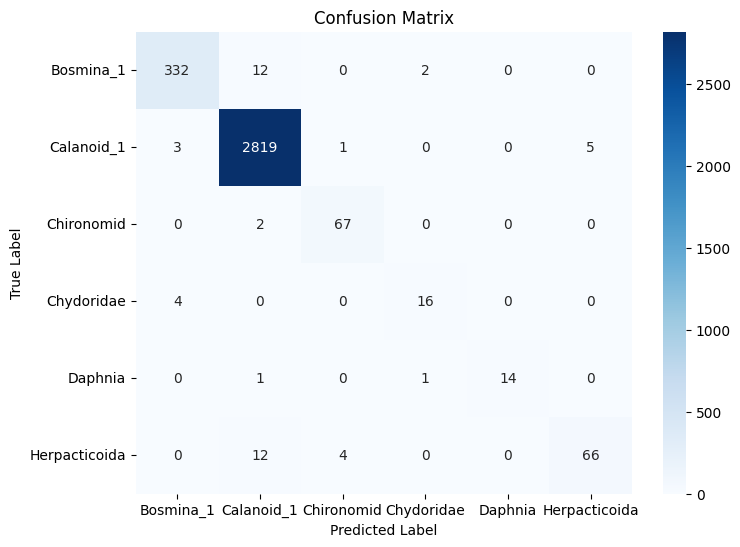

               precision    recall  f1-score   support

    Bosmina_1       0.98      0.96      0.97       346
   Calanoid_1       0.99      1.00      0.99      2828
   Chironomid       0.93      0.97      0.95        69
   Chydoridae       0.84      0.80      0.82        20
      Daphnia       1.00      0.88      0.93        16
Herpacticoida       0.93      0.80      0.86        82

     accuracy                           0.99      3361
    macro avg       0.95      0.90      0.92      3361
 weighted avg       0.99      0.99      0.99      3361



In [35]:
# Load the trained model
collab_model = tf.keras.models.load_model("Modelling/CollaborativeModel/final_collab_model.keras")

# Class label dictionary
class_label_dict = {
    "class_Bosmina_1": "Bosmina_1", 
    "class_Calanoid_1": "Calanoid_1", 
    "class_Chironomid": "Chironomid", 
    "class_Chydoridae": "Chydoridae", 
    "class_Daphnia": "Daphnia", 
    "class_Herpacticoida": "Herpacticoida"
}

# Convert dictionary keys to a sorted list of class names (ensure correct order)
class_names = list(class_label_dict.values())

# Get predicted probabilities
y_pred_probs = collab_model.predict([testAttrX, testImagesX])

# Convert probabilities to class predictions
y_pred = np.argmax(y_pred_probs, axis=1)

# Ensure testY is in integer format (if it's one-hot encoded)
y_true = np.argmax(testY, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=class_names))

In [38]:
collab_model.summary()

Model: "functional_213"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22      │ (None, 137)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_23      │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_211      │ (None, 256)       │     36,352 │ input_layer_22[0… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_212      │ (None, 1536)      │ 12,936,766 │ input_layer_23[0… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 1792)      │          0 │ functional_211[0… │
│ (Concatenate)       │                   │            │ functional_212[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_82 (Dense)    │ (None, 512)       │    918,016 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_83 (Dense)    │ (None, 6)         │      3,078 │ dense_82[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 15,814,226 (60.33 MB)

 Trainable params: 960,006 (3.66 MB)

 Non-trainable params: 12,934,206 (49.34 MB)

 Optimizer params: 1,920,014 (7.32 MB)